## Plots all figures in the paper

In [1]:
base_dir = 'results/'
dir_individual = base_dir + 'individual/'
dir_discriminator = base_dir + 'discriminator_test/'
census_file = base_dir + 'pums_2019.csv'

In [2]:
import os
from tqdm import tqdm

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if not os.path.exists('plots/'):
    os.makedirs('plots/')

In [3]:
from plot_utils.models import hf_models, openai_models, model_names, instruct, model_sizes

all_models = sorted(hf_models + openai_models, key=lambda x: model_sizes[x])
base_models = sorted(list(set(all_models) - set(instruct.keys())), key=lambda x: model_sizes[x])
instruction_models = sorted(list(instruct.keys()), key=lambda x: model_sizes[x])

### Load responses

In [4]:
from plot_utils.plot_utils import acs_categories as n_categories
from plot_utils.plot_utils import load_acs_census_responses
from surveying_llms.load_responses import load_naive_responses, load_adjusted_responses

variables = list(n_categories.keys())
uniform_responses = {var: np.ones(n_categories[var]) / n_categories[var] for var in variables}
census_responses = load_acs_census_responses(census_file, n_categories)
naive_responses = load_naive_responses(dir_individual, base_models, n_categories, openai_models)
choice_responses, adjusted_responses = load_adjusted_responses(dir_individual, all_models, 
                                                               n_categories, openai_models)

Loading naive responses...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 635.38it/s]


Loading adjusted responses...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 22.97it/s]


In [5]:
from plot_utils.plot_utils import compute_entropy, compute_kl

uniform_entropies = {var: compute_entropy(uniform_responses[var]) for var in variables}
census_norm_entropies = {v: compute_entropy(census_responses[v]) / uniform_entropies[v] for v in variables}
naive_norm_entropies = {v: {m: compute_entropy(naive_responses[v][m]) / uniform_entropies[v] 
                            for m in base_models} for v in variables}
adjusted_norm_entropies = {v: {m: compute_entropy(adjusted_responses[v][m]) / uniform_entropies[v] 
                            for m in all_models} for v in variables}


kl_uniform_census = {v: compute_kl(uniform_responses[v], census_responses[v]) for v in variables}
adjusted_kl_census = {v: {m: compute_kl(adjusted_responses[v][m], census_responses[v])
                   for m in all_models} for v in variables}
adjusted_kl_uniform = {v: {m: compute_kl(adjusted_responses[v][m], uniform_responses[v])
                   for m in all_models} for v in variables}

### Figures 1b and 3b

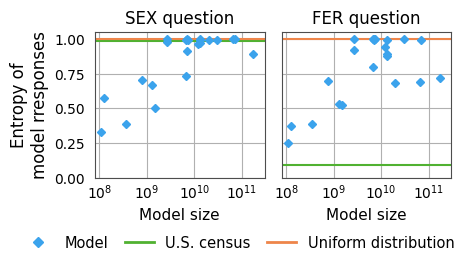

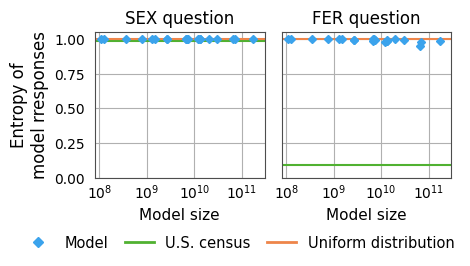

In [6]:
from plot_utils.plot_utils import figure_1b

figure_1b(naive_norm_entropies, census_norm_entropies, base_models, model_sizes)
plt.savefig('plots/naive_sex_fer.pdf', bbox_inches='tight')

figure_1b(adjusted_norm_entropies, census_norm_entropies, base_models, model_sizes)
plt.savefig('plots/adjusted_sex_fer.pdf', bbox_inches='tight')

### Figures 2a and 2b

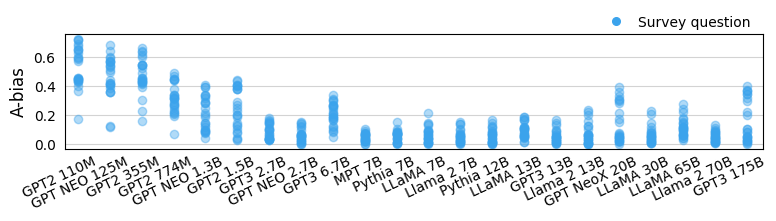

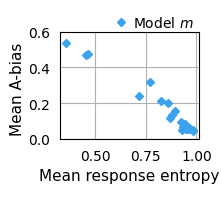

In [7]:
from plot_utils.plot_utils import plot_a_bias, plot_abias_vs_entropy

a_bias = {m: [abs(choice_responses[v][m][0] - (1. / n_categories[v])) for v in variables] for m in base_models}
plot_a_bias(a_bias, base_models, model_names)
plt.savefig('plots/a_bias.pdf', bbox_inches='tight')

mean_a_bias = [np.mean(a_bias[m]) for m in base_models]
mean_entropy = [np.mean([naive_norm_entropies[v][m] for v in variables]) for m in base_models]
plot_abias_vs_entropy(mean_entropy, mean_a_bias)
plt.savefig('plots/abias-vs-entropy.pdf', bbox_inches='tight')

### Figure 4  and Figure 5a

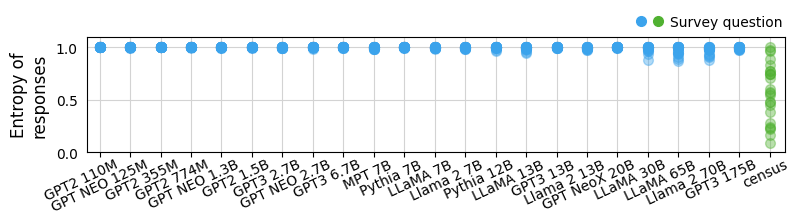

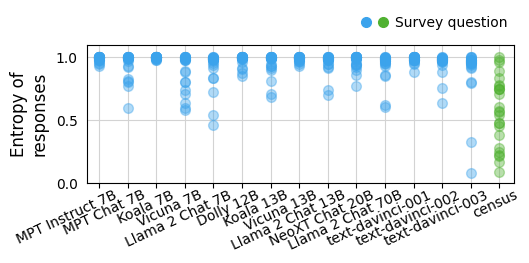

In [8]:
from plot_utils.plot_utils import plot_adjusted_entropy

plot_adjusted_entropy(adjusted_norm_entropies, census_norm_entropies, 
                      base_models, variables, model_names, figsize=(9, 1.5))
plt.savefig('plots/adjusted_entropy.pdf', bbox_inches='tight')

plot_adjusted_entropy(adjusted_norm_entropies, census_norm_entropies, 
                      instruction_models, variables, model_names, figsize=(5.5, 1.8))
plt.savefig('plots/adjusted_entropy_ft.pdf', bbox_inches='tight')

### Figure 5b

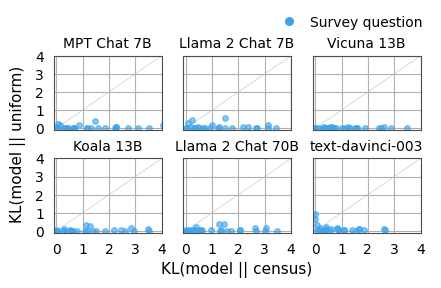

In [9]:
from plot_utils.plot_utils import plot_kl_unif_census

plot_models = ['mpt-chat', 'llama2-7b-chat', 'vicuna13b', 'koala13b', 'llama2-70b-chat', 'text-davinci-003']
plot_kl_unif_census(plot_models, adjusted_kl_census, adjusted_kl_uniform, variables, model_names)
plt.savefig('plots/kl_uniform.pdf', bbox_inches='tight')

In [10]:
frac = {m: 0 for m in all_models}
for m in all_models:
    for v in variables:
        if adjusted_kl_uniform[v][m] >= adjusted_kl_census[v][m]:
            frac[m] += 1
frac = {k: v / len(variables) for k, v in frac.items()}
print('Largest fraction of questions closer to census than to uniform: %.2f' % (max(frac.values())))

Largest fraction of questions closer to census than to uniform: 0.12


### Figure 6 <a name="fig6"></a>

In [11]:
from plot_utils.plot_utils import load_acs_state_responses
states, responses_states = load_acs_state_responses(census_file, n_categories)

# calculate divergence between adjusted responses and each state
subgroup_kls = {}
for m in all_models:
    subgroup_kls[m] = {s: {v: compute_kl(adjusted_responses[v][m], responses_states[v][s]) 
                           for v in variables} for s in states}
    
# Do not consider ESR and JWTRNS since they contain choices with zero frequency for some of the states
variables_used = list(set(variables) - {'ESR', 'JWTRNS'})
divergence = {m: {s: np.mean([subgroup_kls[m][s][v] for v in variables_used])
                  for s in states} for m in all_models}
divergence_uniform = {m: np.mean([compute_kl(adjusted_responses[v][m], uniform_responses[v])
                                  for v in variables_used]) for m in all_models}

Loading ACS responses by state...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.80it/s]
/Users/rdo/Desktop/surve-llm/plot_utils/plot_utils.py:41: RuntimeWarning: divide by zero encountered in divide
  return np.sum(pnz * np.log2(pnz / qnz))


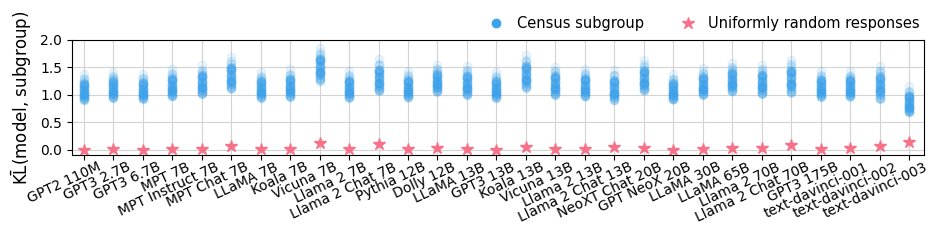

In [12]:
from plot_utils.plot_utils import plot_divergence_subgroups

fewer_models = list(set(all_models) - set(['gptneo125m', 'gpt2m', 'gpt2l', 
                                      'gptneo1.3b', 'gpt2xl', 'gptneo2.7b', 'pythia7']))
fewer_models = sorted(fewer_models, key=lambda x: model_sizes[x])

plot_divergence_subgroups(divergence, divergence_uniform, fewer_models, model_names)
plt.savefig('plots/adjusted_kl_subgroups.pdf', bbox_inches='tight')

### Figure 8

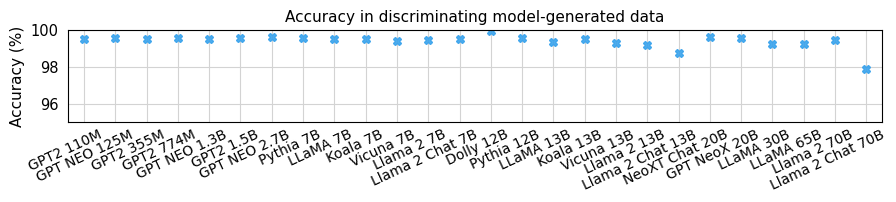

In [13]:
from plot_utils.plot_utils import plot_discriminator
discriminator_models = list(set(hf_models) - set(['mpt', 'mpt-chat', 'mpt-instruct']))
discriminator_models = sorted(discriminator_models, key=lambda x: model_sizes[x])
accuracies = {m: pd.read_csv(f'{dir_discriminator}summary/{m}_accuracies.csv')['xgboost'] 
              for m in discriminator_models}
plot_discriminator(accuracies, discriminator_models, model_names)
plt.savefig('plots/discriminator_test.pdf', bbox_inches='tight')